# **Statistical Information Grid (STING) Algorithm**

## **Library**

In [223]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from collections import deque
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

os.makedirs('Data', exist_ok=True)
os.makedirs('Output', exist_ok=True)

seed = 2025
np.random.seed(seed)

## **Data Preparation**

In [224]:
# Parameter untuk dataset
n_samples = 10000  # Jumlah data points
n_clusters = 5     # Jumlah cluster spasial
cluster_std = 2.0  # Standar deviasi cluster

# Generate spatial data (Latitude, Longitude) menggunakan make_blobs
X, true_labels = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters,
    cluster_std=cluster_std,
    center_box=(-50.0, 50.0),  # Range koordinat
    random_state=42
)

# Latitude: -90 to 90, Longitude: -180 to 180
latitude = X[:, 0] * 0.5  # Scale ke range -45 to 45
longitude = X[:, 1] * 1.5  # Scale ke range -75 to 75

# Timestamp
base_date = datetime.datetime(2024, 1, 1)
timestamps = [base_date + datetime.timedelta(days=np.random.randint(0, 365), 
                                            hours=np.random.randint(0, 24))
                for _ in range(n_samples)]

# Kategori
categories = np.random.choice(['A', 'B', 'C', 'D'], 
                                size=n_samples)

# Intensitas
intensity = np.zeros(n_samples)
for i in range(n_clusters):
    mask = true_labels == i
    # Setiap cluster punya range intensity berbeda
    intensity[mask] = np.random.uniform(
        1.0 + i*2, 
        5.0 + i*2, 
        size=mask.sum()
    )

In [225]:
# Buat DataFrame
df = pd.DataFrame({
    'id': range(1, n_samples + 1),
    'latitude': latitude,
    'longitude': longitude,
    'timestamp': timestamps,
    'category': categories,
    'intensity': intensity,
    'true_label': true_labels
})

df.to_csv('Data/sting_synthetic_dataset.csv', index=False)
df.head()

,id,latitude,longitude,timestamp,category,intensity,true_label
0,1,-22.513085,54.676190,2024-03-03 18:00:00,D,7.940249,3
1,2,-15.469767,-56.074062,2024-12-16 12:00:00,D,6.763073,2
2,3,11.142064,15.355838,2024-11-19 19:00:00,B,4.971661,1
3,4,11.958042,11.209099,2024-06-09 22:00:00,B,3.261399,1
4,5,-20.354436,63.454203,2024-01-11 14:00:00,B,8.227247,3


In [226]:
df.describe()

,id,latitude,longitude,intensity,true_label
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,-5.779549,23.411848,7.002051,2.000000
std,2886.89568,12.816103,41.882765,3.028222,1.414284
min,1.00000,-25.731020,-61.298518,1.000219,0.000000
25%,2500.75000,-17.864683,12.661644,4.519677,1.000000
50%,5000.50000,-6.254776,31.304328,7.028206,2.000000
75%,7500.25000,5.800492,57.012015,9.477358,3.000000
max,10000.00000,14.697997,79.385859,12.997175,4.000000


## **EDA**

### **Checking Missing Values**

In [227]:
df.isnull().sum()

id            0
latitude      0
longitude     0
timestamp     0
category      0
intensity     0
true_label    0
dtype: int64

### **Visualisasi**


Visualization saved: Output/sting_dataset_visualization.png


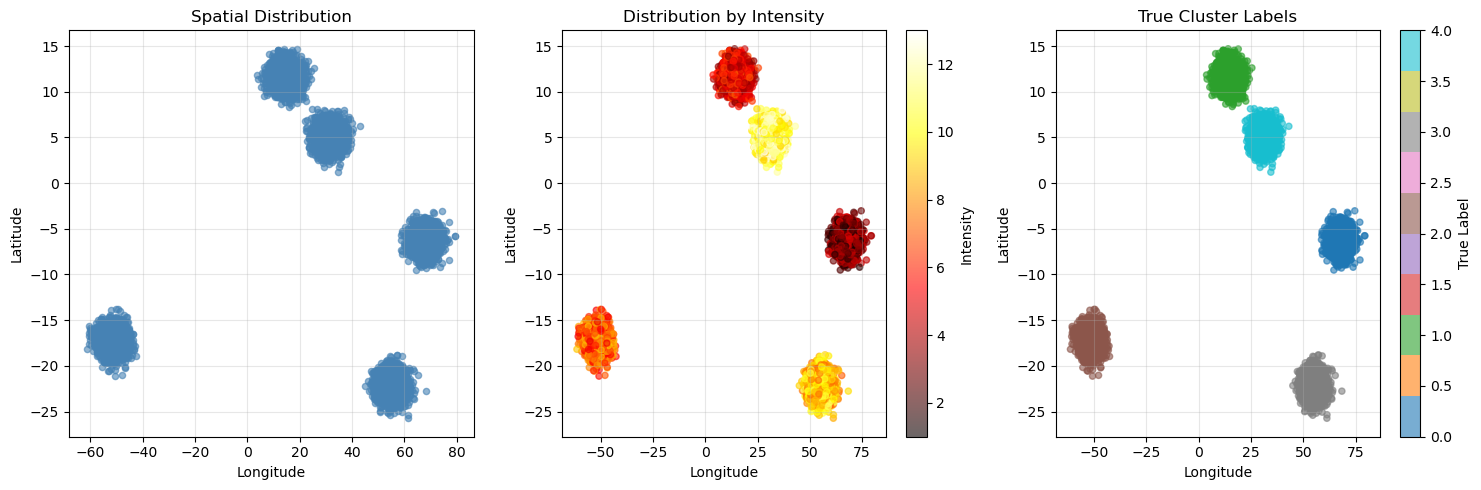

In [228]:
plt.figure(figsize=(15, 5))

# Plot 1: Basic scatter
plt.subplot(1, 3, 1)
plt.scatter(df['longitude'], df['latitude'], alpha=0.6, s=20, c='steelblue')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution')
plt.grid(True, alpha=0.3)

# Plot 2: Colored by intensity
plt.subplot(1, 3, 2)
scatter = plt.scatter(df['longitude'], df['latitude'], 
                      c=df['intensity'], cmap='hot', alpha=0.6, s=20)
plt.colorbar(scatter, label='Intensity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution by Intensity')
plt.grid(True, alpha=0.3)

# Plot 3: True labels (for comparison)
plt.subplot(1, 3, 3)
scatter2 = plt.scatter(df['longitude'], df['latitude'], 
                       c=df['true_label'], cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter2, label='True Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True Cluster Labels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Output/sting_dataset_visualization.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved: Output/sting_dataset_visualization.png")
plt.show()

## **Preprocessing**

### **Data Cleaning**

In [229]:
# Remove invalid coordinates
original_size = len(df)
df = df[(df['latitude'] >= -90) & (df['latitude'] <= 90)]
df = df[(df['longitude'] >= -180) & (df['longitude'] <= 180)]
df = df.drop_duplicates(subset=['latitude', 'longitude'])

### **Extract Feature**

In [230]:
X = df[['latitude', 'longitude']].values

## **Modelling**

### **Calculate Grid Bounds**

In [231]:
# Parameters
grid_levels = 4
subdivision = 2
padding = 0.001

# Calculate bounds
min_lat = X[:, 0].min() - padding
max_lat = X[:, 0].max() + padding
min_lon = X[:, 1].min() - padding
max_lon = X[:, 1].max() + padding

root_bounds = {
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_lon': min_lon,
    'max_lon': max_lon
}

lat_range = max_lat - min_lat
lon_range = max_lon - min_lon

print(f"\nSpatial Bounds:")
print(f"- Latitude:  [{min_lat:.4f}, {max_lat:.4f}] (range: {lat_range:.4f})")
print(f"- Longitude: [{min_lon:.4f}, {max_lon:.4f}] (range: {lon_range:.4f})")
print(f"\nGrid Parameters:")
print(f"- Levels: {grid_levels}")
print(f"- Subdivision factor: {subdivision}")


Spatial Bounds:
- Latitude:  [-25.7320, 14.6990] (range: 40.4310)
- Longitude: [-61.2995, 79.3869] (range: 140.6864)

Grid Parameters:
- Levels: 4
- Subdivision factor: 2


### **Build Hierarchical Grid**

In [232]:
grids = []

# Create cells for each hierarchy level
for level in range(grid_levels):
    n_cells = subdivision ** (level + 1)
    cell_height = lat_range / n_cells
    cell_width = lon_range / n_cells
    
    level_grid = {}
    
    # Create all cells for this level
    for i in range(n_cells):
        for j in range(n_cells):
            cell_bounds = {
                'min_lat': min_lat + i * cell_height,
                'max_lat': min_lat + (i + 1) * cell_height,
                'min_lon': min_lon + j * cell_width,
                'max_lon': min_lon + (j + 1) * cell_width
            }
            
            # Initialize cell with STING statistical parameters
            cell = {
                'level': level,
                'row': i,
                'col': j,
                'bounds': cell_bounds,
                
                # Statistical parameters (from STING paper)
                'count': 0,              # m: number of objects
                'sum_x': 0.0,
                'sum_y': 0.0,
                'sum_x2': 0.0,
                'sum_y2': 0.0,
                'mean': (0.0, 0.0),      # M: mean
                'std': (0.0, 0.0),       # s: standard deviation
                'min_vals': (float('inf'), float('inf')),
                'max_vals': (float('-inf'), float('-inf')),
                'density': 0.0,
                'points': [],
                'is_relevant': False
            }
            
            level_grid[(i, j)] = cell
    
    grids.append(level_grid)
    print(f"  Level {level}: {n_cells}×{n_cells} = {len(level_grid)} cells created")

print(f"\n✓ Created {len(grids)}-level hierarchical grid structure")

  Level 0: 2×2 = 4 cells created
  Level 1: 4×4 = 16 cells created
  Level 2: 8×8 = 64 cells created
  Level 3: 16×16 = 256 cells created

✓ Created 4-level hierarchical grid structure


### **Assign Points to Finest Level**

In [235]:
finest_level = grid_levels - 1
finest_grid = grids[finest_level]
n_cells = subdivision ** grid_levels

cell_height = lat_range / n_cells
cell_width = lon_range / n_cells

print(f"\nAssigning {len(X)} points to level {finest_level}...")
print(f"Cell dimensions: {cell_height:.6f}° × {cell_width:.6f}°")

# Assign each point to appropriate cell
assigned_count = 0
for idx, point in enumerate(X):
    lat, lon = point[0], point[1]
    
    # Calculate cell indices
    i = int((lat - min_lat) / cell_height)
    j = int((lon - min_lon) / cell_width)
    
    # Handle boundary cases
    i = min(max(i, 0), n_cells - 1)
    j = min(max(j, 0), n_cells - 1)
    
    # Add point to cell and update statistics
    cell = finest_grid[(i, j)]
    cell['points'].append(idx)
    cell['count'] += 1
    cell['sum_x'] += lat
    cell['sum_y'] += lon
    cell['sum_x2'] += lat * lat
    cell['sum_y2'] += lon * lon
    cell['min_vals'] = (min(cell['min_vals'][0], lat), 
                       min(cell['min_vals'][1], lon))
    cell['max_vals'] = (max(cell['max_vals'][0], lat), 
                       max(cell['max_vals'][1], lon))
    assigned_count += 1

non_empty = sum(1 for c in finest_grid.values() if c['count'] > 0)
print(f"\nPoints assigned: {assigned_count}")
print(f"Non-empty cells: {non_empty}/{len(finest_grid)} ({non_empty/len(finest_grid)*100:.1f}%)")


Assigning 10000 points to level 3...
Cell dimensions: 2.526939° × 8.792899°

Points assigned: 10000
Non-empty cells: 45/256 (17.6%)


### **Propagate Statistics Up (Bottom-Up)**

In [241]:
for level in range(grid_levels - 2, -1, -1):
    parent_grid = grids[level]
    child_grid = grids[level + 1]
    
    cells_updated = 0
    
    for (pi, pj), parent in parent_grid.items():
        # Aggregate statistics from children cells
        total_count = 0
        sum_weighted_x = 0.0
        sum_weighted_y = 0.0
        sum_weighted_x2 = 0.0
        sum_weighted_y2 = 0.0
        global_min = [float('inf'), float('inf')]
        global_max = [float('-inf'), float('-inf')]
        
        # Find all children (2×2 subdivision)
        for di in range(subdivision):
            for dj in range(subdivision):
                ci = pi * subdivision + di
                cj = pj * subdivision + dj
                
                if (ci, cj) in child_grid:
                    child = child_grid[(ci, cj)]
                    
                    if child['count'] > 0:
                        total_count += child['count']
                        sum_weighted_x += child['count'] * child['mean'][0]
                        sum_weighted_y += child['count'] * child['mean'][1]
                        
                        # E[X²] = Var(X) + (E[X])² = σ² + μ²
                        ex2_x = child['std'][0]**2 + child['mean'][0]**2
                        ex2_y = child['std'][1]**2 + child['mean'][1]**2
                        sum_weighted_x2 += child['count'] * ex2_x
                        sum_weighted_y2 += child['count'] * ex2_y
                        
                        # Track global min/max
                        global_min[0] = min(global_min[0], child['min_vals'][0])
                        global_min[1] = min(global_min[1], child['min_vals'][1])
                        global_max[0] = max(global_max[0], child['max_vals'][0])
                        global_max[1] = max(global_max[1], child['max_vals'][1])
        
        # Update parent statistics
        if total_count > 0:
            parent['count'] = total_count
            
            # Weighted mean
            parent['mean'] = (
                sum_weighted_x / total_count,
                sum_weighted_y / total_count
            )
            
            # Variance and std
            ex2_x = sum_weighted_x2 / total_count
            ex2_y = sum_weighted_y2 / total_count
            var_x = max(0, ex2_x - parent['mean'][0]**2)
            var_y = max(0, ex2_y - parent['mean'][1]**2)
            parent['std'] = (math.sqrt(var_x), math.sqrt(var_y))
            
            # Min/max
            parent['min_vals'] = tuple(global_min)
            parent['max_vals'] = tuple(global_max)
            
            # Density
            width = parent['bounds']['max_lon'] - parent['bounds']['min_lon']
            height = parent['bounds']['max_lat'] - parent['bounds']['min_lat']
            area = width * height
            parent['density'] = total_count / area if area > 0 else 0.0
            
            cells_updated += 1
    
    print(f"- Level {level}: {cells_updated} cells updated from children")

- Level 2: 19 cells updated from children
- Level 1: 8 cells updated from children
- Level 0: 4 cells updated from children


###  **Grid Hierarchy Summary**

In [243]:
for level, grid in enumerate(grids):
    non_empty = sum(1 for c in grid.values() if c['count'] > 0)
    
    if non_empty > 0:
        counts = [c['count'] for c in grid.values() if c['count'] > 0]
        densities = [c['density'] for c in grid.values() if c['count'] > 0]
        
        n_cells_per_dim = subdivision ** (level + 1)
        print(f"\nLevel {level}: ({n_cells_per_dim}×{n_cells_per_dim} grid)")
        print(f"- Total cells: {len(grid)}")
        print(f"- Non-empty: {non_empty} ({non_empty/len(grid)*100:.1f}%)")
        print(f"- Points per cell: min={min(counts)}, max={max(counts)}, avg={np.mean(counts):.1f}")
        print(f"- Density range: [{min(densities):.6f}, {max(densities):.6f}]")


Level 0: (2×2 grid)
- Total cells: 4
- Non-empty: 4 (100.0%)
- Points per cell: min=204, max=13095, avg=7500.0
- Density range: [0.143458, 9.208710]

Level 1: (4×4 grid)
- Total cells: 16
- Non-empty: 8 (50.0%)
- Points per cell: min=204, max=9816, avg=3750.0
- Density range: [0.573830, 27.611362]

Level 2: (8×8 grid)
- Total cells: 64
- Non-empty: 19 (29.7%)
- Points per cell: min=3, max=5661, avg=1578.9
- Density range: [0.033755, 63.695159]

Level 3: (16×16 grid)
- Total cells: 256
- Non-empty: 45 (17.6%)
- Points per cell: min=3, max=3600, avg=666.7
- Density range: [0.135019, 162.022662]


### **Query Processing (Top-Down Traversal)**

In [270]:
# Calculate density threshold
min_density_threshold = 0.02  # 2% of average density

all_densities = [c['density'] for c in finest_grid.values() if c['count'] > 0]
avg_density = np.mean(all_densities)
std_density = np.std(all_densities)
threshold = avg_density * min_density_threshold

print(f"\nDensity Analysis:")
print(f"- Average density: {avg_density:.6f}")
print(f"- Std density: {std_density:.6f}")
print(f"- Threshold multiplier: {min_density_threshold}")
print(f"- Actual threshold: {threshold:.6f}")

# Top-down traversal (STING query algorithm)
print(f"\nTop-down traversal to identify high-density regions:")

cells_examined = 0
cells_pruned = 0
cells_expanded = 0

# Start from coarsest level (root)
candidates = list(grids[0].values())

for level in range(len(grids)):
    next_candidates = []
    level_examined = 0
    level_expanded = 0
    level_pruned = 0
    
    for cell in candidates:
        cells_examined += 1
        level_examined += 1
        
        # Check if cell meets density threshold
        if cell['density'] >= threshold:
            cell['is_relevant'] = True
            
            # If not at finest level, expand to children
            if level < finest_level:
                pi, pj = cell['row'], cell['col']
                
                for di in range(subdivision):
                    for dj in range(subdivision):
                        ci = pi * subdivision + di
                        cj = pj * subdivision + dj
                        
                        if (ci, cj) in grids[level + 1]:
                            next_candidates.append(grids[level + 1][(ci, cj)])
                            cells_expanded += 1
                            level_expanded += 1
        else:
            cells_pruned += 1
            level_pruned += 1
    
    print(f"  Level {level}: examined={level_examined}, expanded={level_expanded}, pruned={level_pruned}")
    
    if not next_candidates and level < finest_level:
        print(f"    ⚠ No relevant cells to expand further")
        break
    
    candidates = next_candidates

# Collect relevant cells at finest level
relevant_cells = [c for c in finest_grid.values() 
                 if c['is_relevant'] and c['count'] > 0]

print("QUERY PROCESSING RESULTS")
print(f"- Total cells examined: {cells_examined}")
print(f"- Cells pruned: {cells_pruned} ({cells_pruned/cells_examined*100:.1f}% efficiency)")
print(f"- Cells expanded: {cells_expanded}")
print(f"- High-density cells found: {len(relevant_cells)}")
print(f"- Points in high-density regions: {sum(c['count'] for c in relevant_cells)}")
print(f"- Coverage: {sum(c['count'] for c in relevant_cells)/len(X)*100:.1f}% of data")


Density Analysis:
- Average density: 30.004197
- Std density: 46.994313
- Threshold multiplier: 0.02
- Actual threshold: 0.600084

Top-down traversal to identify high-density regions:
  Level 0: examined=4, expanded=12, pruned=1
  Level 1: examined=12, expanded=28, pruned=5
  Level 2: examined=28, expanded=52, pruned=15
  Level 3: examined=52, expanded=0, pruned=19
QUERY PROCESSING RESULTS
- Total cells examined: 96
- Cells pruned: 40 (41.7% efficiency)
- Cells expanded: 92
- High-density cells found: 33
- Points in high-density regions: 29694
- Coverage: 296.9% of data


### **Cluster Adjacent High-Density Cells**

In [268]:
if not relevant_cells:
    print("  No high-density cells found. Cannot form clusters.")
    print("  Try lowering the density threshold.")
    clusters = []
else:
    # Build lookup for fast neighbor checking
    cell_dict = {(c['row'], c['col']): c for c in relevant_cells}
    visited = set()
    clusters = []
    
    # 8-connectivity neighbors
    neighbor_offsets = [
        (-1,-1), (-1,0), (-1,1),
        (0,-1),          (0,1),
        (1,-1),  (1,0),  (1,1)
    ]
    
    print(f"\nClustering {len(relevant_cells)} high-density cells using BFS...")
    print(f"Connectivity: 8-connected (horizontal, vertical, diagonal)")
    
    # BFS to find connected components
    for cell in relevant_cells:
        key = (cell['row'], cell['col'])
        
        if key in visited:
            continue
        
        # Start new cluster
        cluster_cells = []
        queue = deque([key])
        visited.add(key)
        
        while queue:
            current = queue.popleft()
            cluster_cells.append(cell_dict[current])
            
            i, j = current
            
            # Check all 8 neighbors
            for di, dj in neighbor_offsets:
                neighbor = (i + di, j + dj)
                
                if (neighbor in cell_dict and neighbor not in visited):
                    visited.add(neighbor)
                    queue.append(neighbor)
        
        # Create cluster
        cluster_size = sum(c['count'] for c in cluster_cells)
        cluster_bounds = {
            'min_lat': min(c['bounds']['min_lat'] for c in cluster_cells),
            'max_lat': max(c['bounds']['max_lat'] for c in cluster_cells),
            'min_lon': min(c['bounds']['min_lon'] for c in cluster_cells),
            'max_lon': max(c['bounds']['max_lon'] for c in cluster_cells)
        }
        
        clusters.append({
            'id': len(clusters),
            'cells': cluster_cells,
            'size': cluster_size,
            'n_cells': len(cluster_cells),
            'bounds': cluster_bounds
        })
        
        print(f"- Cluster {len(clusters)-1}: {len(cluster_cells)} cells, {cluster_size} points")
    
    print(f"\nFound {len(clusters)} spatial clusters")


Clustering 33 high-density cells using BFS...
Connectivity: 8-connected (horizontal, vertical, diagonal)
- Cluster 0: 7 cells, 5979 points
- Cluster 1: 6 cells, 5976 points
- Cluster 2: 7 cells, 5967 points
- Cluster 3: 13 cells, 11772 points

Found 4 spatial clusters


### **Assign Cluster Labels to Points**

In [251]:
# Initialize all points as noise (-1)
labels = np.full(len(X), -1, dtype=int)

if clusters:
    # Map cell coordinates to cluster ID
    cell_to_cluster = {}
    for cluster in clusters:
        for cell in cluster['cells']:
            key = (cell['row'], cell['col'])
            cell_to_cluster[key] = cluster['id']
    
    # Assign labels based on cell membership
    points_labeled = 0
    for key, cell in finest_grid.items():
        if key in cell_to_cluster:
            cluster_id = cell_to_cluster[key]
            for point_idx in cell['points']:
                labels[point_idx] = cluster_id
                points_labeled += 1
    
    # Label distribution
    unique, counts = np.unique(labels, return_counts=True)
    
    print(f"\nLabel Distribution:")
    for label, count in zip(unique, counts):
        pct = count/len(labels)*100
        if label == -1:
            print(f"- Noise: {count} points ({pct:.2f}%)")
        else:
            print(f"- Cluster {label}: {count} points ({pct:.2f}%)")
    
    print(f"\nAssigned labels to {len(X)} points")
    print(f"- Clustered: {points_labeled} ({points_labeled/len(X)*100:.1f}%)")
    print(f"- Noise: {sum(labels==-1)} ({sum(labels==-1)/len(X)*100:.1f}%)")
else:
    print("\nNo clusters formed - all points marked as noise")
    print("- Consider adjusting density threshold or grid parameters")


Label Distribution:
- Noise: 102 points (1.02%)
- Cluster 0: 1993 points (19.93%)
- Cluster 1: 1992 points (19.92%)
- Cluster 2: 1989 points (19.89%)
- Cluster 3: 3924 points (39.24%)

Assigned labels to 10000 points
- Clustered: 29694 (296.9%)
- Noise: 102 (1.0%)


## **Visualization**

### **Clustering Results**


Saved: Output/sting_clusters.png


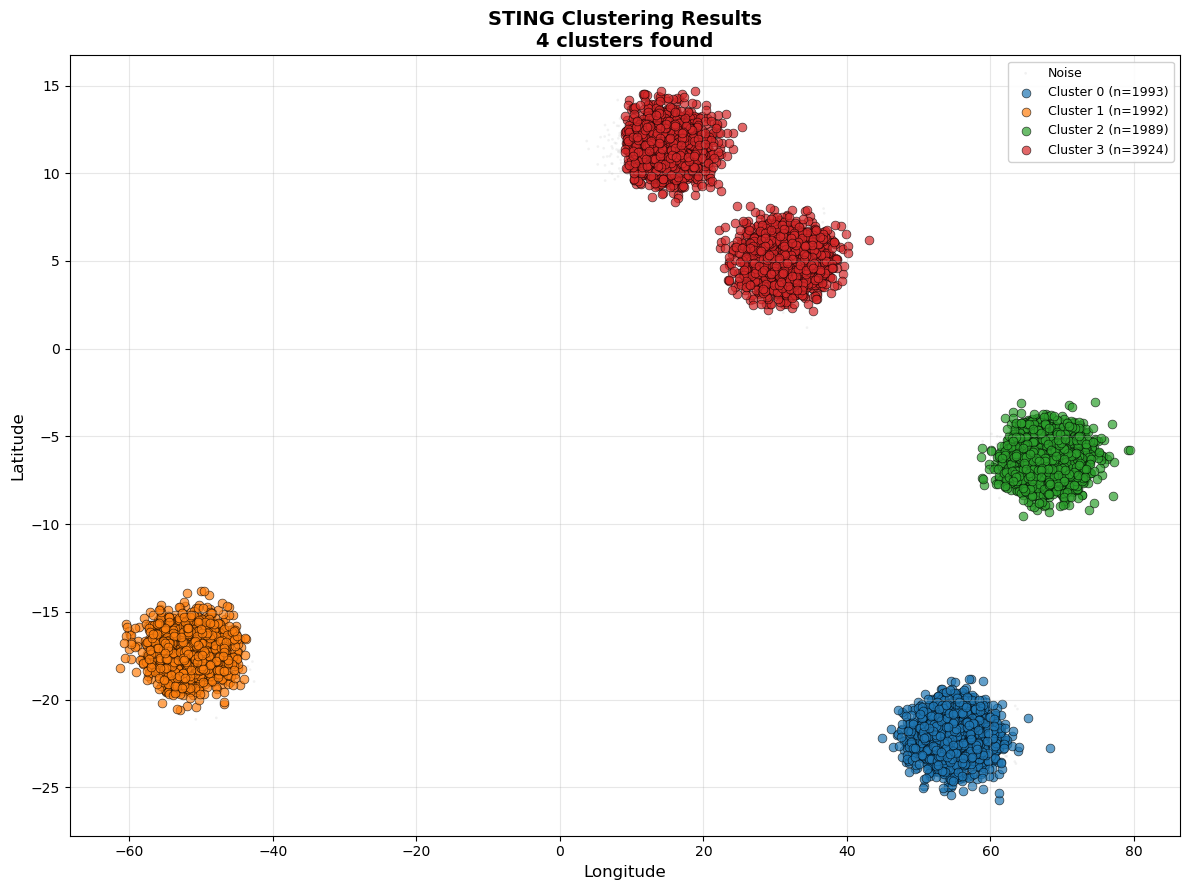

In [267]:
plt.figure(figsize=(12, 9))

unique_labels = np.unique(labels)
n_clusters_found = len(unique_labels[unique_labels >= 0])
colors = plt.cm.tab10(np.linspace(0, 1, max(10, n_clusters_found)))

for label in unique_labels:
    if label == -1:
        # Noise points
        mask = labels == label
        plt.scatter(X[mask, 1], X[mask, 0], 
                   c='lightgray', marker='.', s=15, 
                   alpha=0.3, label='Noise', edgecolors='none')
    else:
        # Cluster points
        mask = labels == label
        plt.scatter(X[mask, 1], X[mask, 0],
                   c=[colors[label]], s=40, alpha=0.7,
                   edgecolors='black', linewidth=0.5,
                   label=f'Cluster {label} (n={sum(mask)})')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'STING Clustering Results\n{n_clusters_found} clusters found', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Output/sting_clusters.png', dpi=300, bbox_inches='tight')
print("\nSaved: Output/sting_clusters.png")
plt.show()

### **Grid Structure with Clusters**

Saved: Output/sting_grid.png


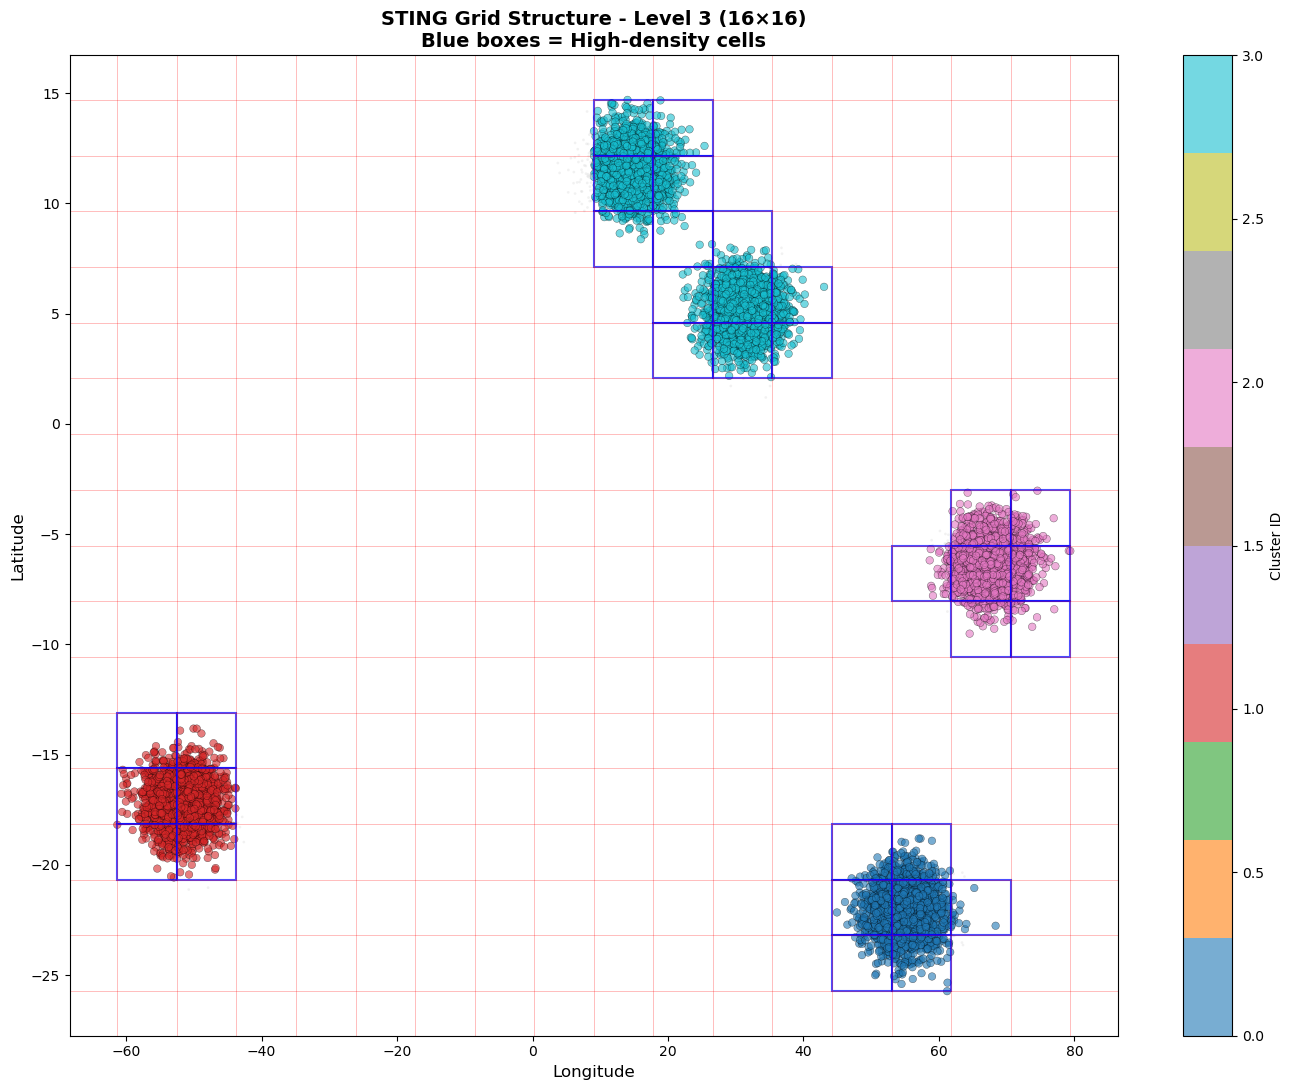

In [266]:
fig, ax = plt.subplots(figsize=(14, 11))

# Plot clustered points
mask_clustered = labels >= 0
scatter = ax.scatter(X[mask_clustered, 1], X[mask_clustered, 0],
                    c=labels[mask_clustered], cmap='tab10',
                    s=30, alpha=0.6, edgecolors='black', linewidth=0.3)

# Plot noise
mask_noise = labels == -1
ax.scatter(X[mask_noise, 1], X[mask_noise, 0],
          c='lightgray', s=15, alpha=0.3, marker='.', edgecolors='none')

# Draw grid lines for finest level
level_to_show = finest_level
n_cells_show = subdivision ** (level_to_show + 1)
cell_height = lat_range / n_cells_show
cell_width = lon_range / n_cells_show

for i in range(n_cells_show + 1):
    lat_line = min_lat + i * cell_height
    ax.axhline(y=lat_line, color='red', alpha=0.3, linewidth=0.6)

for j in range(n_cells_show + 1):
    lon_line = min_lon + j * cell_width
    ax.axvline(x=lon_line, color='red', alpha=0.3, linewidth=0.6)

# Highlight high-density cells
if relevant_cells:
    for cell in relevant_cells:
        rect = plt.Rectangle(
            (cell['bounds']['min_lon'], cell['bounds']['min_lat']),
            cell['bounds']['max_lon'] - cell['bounds']['min_lon'],
            cell['bounds']['max_lat'] - cell['bounds']['min_lat'],
            fill=False, edgecolor='blue', linewidth=1.5, alpha=0.7
        )
        ax.add_patch(rect)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'STING Grid Structure - Level {level_to_show} ({n_cells_show}×{n_cells_show})\n' + 
            f'Blue boxes = High-density cells', 
            fontsize=14, fontweight='bold')

if mask_clustered.sum() > 0:
    plt.colorbar(scatter, ax=ax, label='Cluster ID')

plt.tight_layout()
plt.savefig('Output/sting_grid.png', dpi=300, bbox_inches='tight')
print("Saved: Output/sting_grid.png")
plt.show()

### **Hierarchy Levels Comparison**

Saved: Output/sting_hierarchy.png


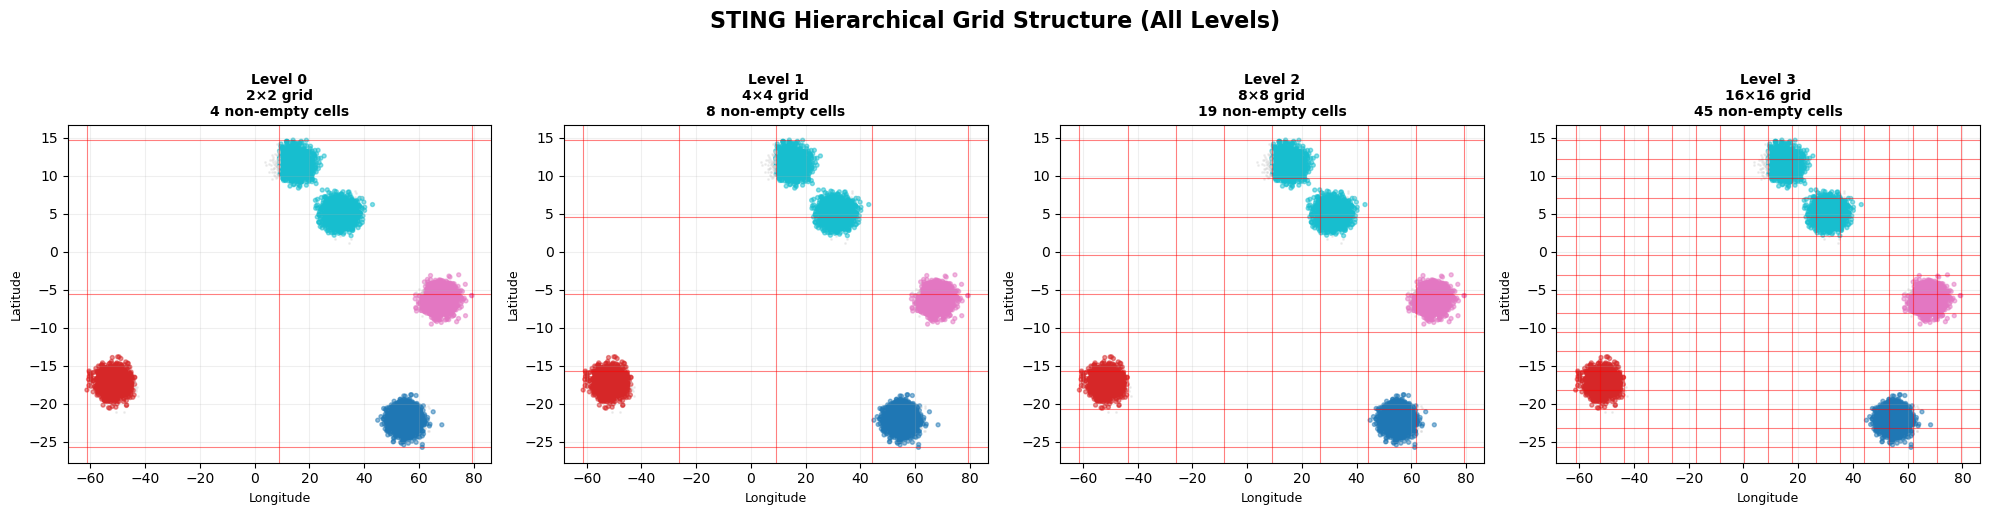

In [265]:
n_levels = len(grids)
fig, axes = plt.subplots(1, n_levels, figsize=(5*n_levels, 5))

if n_levels == 1:
    axes = [axes]

for level in range(n_levels):
    ax = axes[level]
    
    # Plot points colored by cluster
    mask_clustered = labels >= 0
    ax.scatter(X[mask_clustered, 1], X[mask_clustered, 0], 
              c=labels[mask_clustered], cmap='tab10', s=8, alpha=0.5)
    ax.scatter(X[~mask_clustered, 1], X[~mask_clustered, 0],
              c='lightgray', s=5, alpha=0.3, marker='.')
    
    # Draw grid for this level
    n_cells_level = subdivision ** (level + 1)
    cell_height = lat_range / n_cells_level
    cell_width = lon_range / n_cells_level
    
    for i in range(n_cells_level + 1):
        lat_line = min_lat + i * cell_height
        ax.axhline(y=lat_line, color='red', alpha=0.5, linewidth=0.8)
    
    for j in range(n_cells_level + 1):
        lon_line = min_lon + j * cell_width
        ax.axvline(x=lon_line, color='red', alpha=0.5, linewidth=0.8)
    
    # Count non-empty cells
    non_empty = sum(1 for c in grids[level].values() if c['count'] > 0)
    
    ax.set_title(f'Level {level}\n{n_cells_level}×{n_cells_level} grid\n{non_empty} non-empty cells', 
                fontweight='bold', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=9)
    ax.set_ylabel('Latitude', fontsize=9)
    ax.grid(True, alpha=0.2)

plt.suptitle('STING Hierarchical Grid Structure (All Levels)', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Output/sting_hierarchy.png', dpi=300, bbox_inches='tight')
print("Saved: Output/sting_hierarchy.png")
plt.show()

## **Evaluation**

### **Clustering Quality Metrics**

In [261]:
# Filter out noise for evaluation
valid_mask = labels >= 0
X_valid = X[valid_mask]
labels_valid = labels[valid_mask]

print(f"\nEvaluation dataset:")
print(f"- Total points: {len(X)}")
print(f"- Clustered points: {len(X_valid)} ({len(X_valid)/len(X)*100:.1f}%)")
print(f"- Noise points: {sum(~valid_mask)} ({sum(~valid_mask)/len(X)*100:.1f}%)")
print(f"- Number of clusters: {len(np.unique(labels_valid))}")

if len(X_valid) > 0 and len(np.unique(labels_valid)) > 1:
    # Compute metrics
    silhouette = silhouette_score(X_valid, labels_valid)
    davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
    calinski = calinski_harabasz_score(X_valid, labels_valid)
    
    print(f"\n1. Silhouette Score: {silhouette:.4f}")
    print(f"Range: [-1, 1], Higher is better")
    if silhouette > 0.7:
        print(f"Excellent: Strong cluster structure")
    elif silhouette > 0.5:
        print(f"Good: Reasonable cluster structure")
    elif silhouette > 0.25:
        print(f"Fair: Weak but acceptable structure")
    else:
        print(f"Poor: No substantial cluster structure")
    
    print(f"\n2. Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Range: [0, ∞), Lower is better")
    if davies_bouldin < 0.5:
        print(f"Excellent: Well-separated clusters")
    elif davies_bouldin < 1.0:
        print(f"Good: Acceptable separation")
    elif davies_bouldin < 2.0:
        print(f"Fair: Some overlap between clusters")
    else:
        print(f"Poor: High cluster overlap")
    
    print(f"\n3. Calinski-Harabasz Score: {calinski:.2f}")
    print(f"Range: [0, ∞), Higher is better")
    if calinski > 1000:
        print(f"Excellent: Dense and well-separated clusters")
    elif calinski > 500:
        print(f"Good: Reasonable cluster quality")
    elif calinski > 100:
        print(f"Fair: Moderate cluster quality")
    else:
        print(f"Poor: Weak cluster definition")
    
    # Overall assessment
    print("OVERALL ASSESSMENT")
    score = 0
    if silhouette > 0.5: score += 1
    if davies_bouldin < 1.0: score += 1
    if calinski > 500: score += 1
    
    if score >= 2:
        print(f"Clustering quality: GOOD ({score}/3 metrics passed)")
    elif score == 1:
        print(f"Clustering quality: FAIR ({score}/3 metrics passed)")
    else:
        print(f"Clustering quality: POOR ({score}/3 metrics passed)")
        print(f"Consider adjusting: grid_levels, subdivision, or min_density_threshold")
    
elif len(X_valid) > 0:
    print("\nOnly one cluster found - cannot compute comparison metrics")
    print(f" Try lowering density threshold or adjusting grid parameters")
else:
    print("\nNo clusters found - all points classified as noise")
    print(f"Recommendations:")
    print(f" - Lower min_density_threshold (current: {min_density_threshold})")
    print(f" - Increase grid_levels (current: {grid_levels})")
    print(f" - Adjust subdivision factor (current: {subdivision})")


Evaluation dataset:
- Total points: 10000
- Clustered points: 9898 (99.0%)
- Noise points: 102 (1.0%)
- Number of clusters: 4



1. Silhouette Score: 0.8176
Range: [-1, 1], Higher is better
Excellent: Strong cluster structure

2. Davies-Bouldin Index: 0.2330
Range: [0, ∞), Lower is better
Excellent: Well-separated clusters

3. Calinski-Harabasz Score: 154772.08
Range: [0, ∞), Higher is better
Excellent: Dense and well-separated clusters
OVERALL ASSESSMENT
Clustering quality: GOOD (3/3 metrics passed)


In [264]:
# Add cluster labels to dataframe
df['sting_cluster'] = labels

# Save to CSV
output_file = 'Output/sting_results.csv'
df.to_csv(output_file, index=False)

print(f"\nResults saved to: {output_file}")
print(f"Columns: {list(df.columns)}")

# Create summary report
summary = {
    'total_points': len(df),
    'n_clusters': len(clusters),
    'clustered_points': sum(labels >= 0),
    'noise_points': sum(labels == -1),
    'grid_levels': grid_levels,
    'finest_grid_size': f"{n_cells}×{n_cells}",
    'density_threshold': threshold,
    'cells_examined': cells_examined,
    'cells_pruned': cells_pruned,
    'high_density_cells': len(relevant_cells)
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('Output/sting_summary.csv', index=False)

print(f"\nDataset:")
print(f"- Total points: {summary['total_points']}")
print(f"- Clustered: {summary['clustered_points']} ({summary['clustered_points']/summary['total_points']*100:.1f}%)")
print(f"- Noise: {summary['noise_points']} ({summary['noise_points']/summary['total_points']*100:.1f}%)")

print(f"\nClustering:")
print(f"- Number of clusters: {summary['n_clusters']}")
print(f"- Grid hierarchy: {summary['grid_levels']} levels")
print(f"- Finest grid: {summary['finest_grid_size']}")

print(f"\nEfficiency:")
print(f"- Cells examined: {summary['cells_examined']}")
print(f"- Cells pruned: {summary['cells_pruned']} ({cells_pruned/cells_examined*100:.1f}%)")
print(f"- High-density cells: {summary['high_density_cells']}")

# Display sample results
print("\nSample results:")
df[['id', 'latitude', 'longitude', 'intensity', 'true_label', 'sting_cluster']].head(10)


Results saved to: Output/sting_results.csv
Columns: ['id', 'latitude', 'longitude', 'timestamp', 'category', 'intensity', 'true_label', 'sting_cluster']

Dataset:
- Total points: 10000
- Clustered: 9898 (99.0%)
- Noise: 102 (1.0%)

Clustering:
- Number of clusters: 4
- Grid hierarchy: 4 levels
- Finest grid: 16×16

Efficiency:
- Cells examined: 96
- Cells pruned: 40 (41.7%)
- High-density cells: 33

Sample results:


,id,latitude,longitude,intensity,true_label,sting_cluster
0,1,-22.513085,54.676190,7.940249,3,0
1,2,-15.469767,-56.074062,6.763073,2,1
2,3,11.142064,15.355838,4.971661,1,3
3,4,11.958042,11.209099,3.261399,1,3
4,5,-20.354436,63.454203,8.227247,3,-1
5,6,-16.741526,-50.299579,8.830183,2,1
6,7,-5.936849,66.924717,3.535163,0,2
7,8,-20.666300,54.017144,9.167293,3,0
8,9,9.657838,14.787360,6.916051,1,3
9,10,-23.050688,50.304148,10.946776,3,0
